In [ ]:
## INSTALL THESE LIBRARES
# ! pip install tensorflow

In [ ]:
TRAINING_SIZE=5000

In [ ]:
import os
import sys
from IPython.display import Markdown, display
import re
from string import punctuation
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

    
def handle_helper_functions():
    print(sys.path)
    directory_path = os.path.abspath(os.path.join('../../helper'))
    if directory_path not in sys.path:
        sys.path.append(directory_path)    

    translation_path=os.path.abspath(os.path.join('../../utils')) 
    if translation_path not in sys.path:
        sys.path.append(translation_path)   
    sys.path.append( '../../utils/')                                       
    sys.path.append( '../../data/' )


    lstm_helper_path = os.path.abspath(os.path.join('./create-model/lstm/'))
    if lstm_helper_path not in sys.path:
        sys.path.append(lstm_helper_path)    

    print(sys.path)
    

handle_helper_functions()

In [ ]:
from iit_dataset import createDataset

In [10]:
class Translator():
    def __init__(self, training_size=10000) -> None:
        self.model=None
        self.training_size=training_size
        self.idx_src=0
        self.idx_tar = 1
        self.source_str, self.target_str = "Hindi", "English"
        self.tar_tokenizer=None #
        self.tar_vocab_size=None #
        self.src_tokenizer=None #
        self.tar_length=None #
        self.src_vocab_size=None #
        self.src_length=None #
        self.trainX=None
        self.trainY=None
        pass

    def _get_training_data(self):
        pool_oftexts, pairs =createDataset(data_size=self.training_size, type="train")
        dataset= pool_oftexts
        return dataset
    
    def clean(self,string):
        string = string.replace("\u202f"," ")
        string = string.lower()
        for p in punctuation + "«»" + "0123456789":
            string = string.replace(p," ")  
        string = re.sub('\s+',' ', string)
        string = string.strip()
            
        return string
    
    def _generate_train_test_split(self):
        ''' 
        GET TRAINING DATA AND SPLIT THEM TO TRAIN AND TEST SET

        RETURN dataset, train, test
        '''
        dataset= self._get_training_data()
        total_sentences= len(dataset)
        test_proportion = 0.1
        train_test_threshold = int( (1-test_proportion) * total_sentences)

        dataset["eng"] = dataset["eng"].apply(lambda x: self.clean(x))
        dataset["hindi"] = dataset["hindi"].apply(lambda x: self.clean(x))

        dataset = dataset.values
        dataset = dataset[:total_sentences]

        train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

        return dataset, train, test
    def create_tokenizer(self,lines):
        # fit a tokenizer
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(lines)
        return tokenizer
 

    def encode_sequences(self,tokenizer, length, lines):
        # encode and pad sequences
        X = tokenizer.texts_to_sequences(lines) # integer encode sequences
        X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
        return X
    
    def encode_output(self,sequences, vocab_size):
        # one hot encode target sequence
        ylist = list()
        for sequence in sequences:
            encoded = to_categorical(sequence, num_classes=vocab_size)
            ylist.append(encoded)
        y = np.array(ylist)
        y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
        return y
 

    def _convert_sentence_to_vectors(self):
        ''' 
        GENERATE TRAIN TEST SPLIT
        CREATE TARGET TOKENIZER
        CREATE SOURCE TOKENIZER
        RETURN VECTORS FOR TRAINING
        '''
        dataset, train, test= self. _generate_train_test_split()
        # Prepare target tokenizer
        tar_tokenizer = self.create_tokenizer(dataset[:, self.idx_tar]) #save
        tar_vocab_size = len(tar_tokenizer.word_index) + 1  #save
        tar_length = 15  #save
        printmd(f'\nTarget ({self.target_str}) Vocabulary Size: {tar_vocab_size}')
        printmd(f'Target ({self.target_str}) Max Length: {tar_length}')

        # Prepare source tokenizer
        src_tokenizer = self.create_tokenizer(dataset[:, self.idx_src])  #save
        src_vocab_size = len(src_tokenizer.word_index) + 1  #save
        src_length = 15  #save
        #### SAVE
        self.tar_tokenizer=tar_tokenizer
        self.tar_vocab_size=tar_vocab_size
        self.src_tokenizer=src_tokenizer
        self.tar_length=tar_length
        self.src_vocab_size=src_vocab_size
        self.src_length=src_length
        ### SAVE
        printmd(f'\nSource ({self.source_str}) Vocabulary Size: {src_vocab_size}')
        printmd(f'Source ({self.source_str}) Max Length: {src_length}\n')
        # PREPARING TRAINING DATA
        trainX = self.encode_sequences(src_tokenizer, src_length, train[:, self.idx_src])
        trainY = self.encode_sequences(tar_tokenizer, tar_length, train[:, self.idx_tar])
        trainY = self.encode_output(trainY, tar_vocab_size)
        self.trainX=trainX
        self.trainY=trainY
        pass
    
    def create_model(self, src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
        # Create the model
        model = Sequential()
        model.add(Embedding(src_vocab, n_units,  mask_zero=True))
        model.add(LSTM(n_units))
        model.add(RepeatVector(tar_timesteps))
        model.add(LSTM(n_units, return_sequences=True))
        model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
        return model
    
    def train(self):
        self._convert_sentence_to_vectors()
        # Create model
        model=self.model
        model = self.create_model(self.src_vocab_size, self.tar_vocab_size, self.src_length, self.tar_length, 256)
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        #######################
        # display("TRAIN X: ",self.trainX)
        # display("TRAIN Y ",self.trainY)
        # display(model)
        #######################
        history = model.fit(self.trainX, 
               self.trainY, 
                epochs=2 ,
                batch_size=64, 
                validation_split=0.1, 
                verbose=1,
                callbacks=[
                                EarlyStopping(
                                monitor='val_loss',
                                patience=10,
                                restore_best_weights=True
                            )
                    ])


        model.summary()
        self.model=model
        # save model in computer '/Users/learn/Desktop/Projects/machine-translation/machine-learning/data'
        # model.save(filepath='../temp_model/')
        self.save_models_and_parameters(total_sentences=TRAINING_SIZE, model= model,src_tokenizer=self.src_tokenizer, tar_tokenizer=self.tar_tokenizer, src_length=self.src_length, tar_length=self.tar_length, src_vocab_size=self.src_vocab_size,tar_vocab_size=self.tar_vocab_size )
        pd.DataFrame(history.history).plot()
        plt.title("Loss")
        plt.show()
        pass

    def save_models_and_parameters( self, total_sentences ,model ,src_tokenizer , tar_tokenizer, src_length, tar_length, src_vocab_size,tar_vocab_size ):
        ''' 
        SAVE MODEL AND OTHER PARAMETERS IN DESIGNATED FOLDER
        '''
        print("MODEL SAVED")
        model_name =str(total_sentences)
        # path="../../model/lstm/"+model_name+"/"
        path='../temp_model/'+model_name+"/"
        
        src_parameters={
            'src_length': src_length,
            'src_vocab_size': src_vocab_size,
        }
        src_tokenizer= src_tokenizer

        target_parameters={
            'target_length': tar_length,
            'target_vocab_size': tar_vocab_size,
        }
        target_tokenizer= tar_tokenizer

        model.save(path+'lstm_model.h5' ) 
        with open(path+'src_parameters.pickle', 'wb') as handle:
            pickle.dump(src_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(path+'src_tokenizer.pickle', 'wb') as handle:
            pickle.dump(src_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(path+'target_parameters.pickle', 'wb') as handle:
            pickle.dump(target_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(path+'target_tokenizer.pickle', 'wb') as handle:
            pickle.dump(target_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        pass

    def load_model(self,model_path ):
        model, src_tokenizer, target_tokenizer, src_parameters, target_parameters= self._load_models_and_parameters(model_path)
        print(model, src_tokenizer, target_tokenizer, src_parameters, target_parameters)
       
        self.model=model
        
        self.src_tokenizer=src_tokenizer
        
        self.tar_tokenizer=target_tokenizer

        self.src_length=src_parameters["src_length"]
        self.src_vocab_size=src_parameters["src_vocab_size"]

        self.tar_length=target_parameters["target_length"]
        self.tar_vocab_size=target_parameters["target_vocab_size"]
        pass

    def _load_models_and_parameters(self, model_size):
        path=model_size+'/'

        model = keras.models.load_model(path+'lstm_model')
        with open(path+ "src_parameters.pickle", 'rb') as handle:
            src_parameters = pickle.load(handle)

        with open(path+ "src_tokenizer.pickle", 'rb') as handle:
            src_tokenizer = pickle.load(handle)

        with open(path+ "target_parameters.pickle", 'rb') as handle:
            target_parameters = pickle.load(handle)

        with open(path+ "target_tokenizer.pickle", 'rb') as handle:
            target_tokenizer = pickle.load(handle)
        return model, src_tokenizer, target_tokenizer, src_parameters, target_parameters
    
    def word_for_id(self,integer, tokenizer):
        # map an integer to a word
        for word, index in tokenizer.word_index.items():
            if index == integer:
                return word
        return None
 
    def predict_seq(self, model, tokenizer, source):
        # generate target from a source sequence
        prediction = model.predict(source, verbose=0)[0]
        integers = [np.argmax(vector) for vector in prediction]
        target = list()
        for i in integers:
            word = self.word_for_id(i, tokenizer)
            if word is None:
                break
            target.append(word)
        return ' '.join(target)
    
    def compare_prediction(self,model, tar_tokenizer, sources, raw_dataset, limit=20):
        # evaluate a model
        actual, predicted  = [], []
        src = f'{self.source_str.upper()} (SOURCE)'
        tgt = f'{self.target_str.upper()} (TARGET)'
        pred = f'AUTOMATIC TRANSLATION IN {self.target_str.upper()}'
        print(f'{src:30} {tgt:25} {pred}\n')
        
        for i, source in enumerate(sources): # translate encoded source text
            source = source.reshape((1, source.shape[0]))
            translation = self.predict_seq(model, tar_tokenizer, source)
            raw_src,raw_target = raw_dataset[i]
            print("##############################################################################")
            print(f' {i+1}. {raw_src:30} || {raw_target:25} || {translation}')
            ## STORE PREDICTIONS
            ############################################
            actual.append(raw_target.split())
            predicted.append(translation.split())
            ############################################
            if i >= limit: # Display some of the result
                break
        return actual, predicted
    
    def genereate_test_results(self):
        data_size=1000

        pool_oftexts, pairs =createDataset(data_size=data_size, type="train")
        dataset= pool_oftexts
        dataset = dataset.values
        test=dataset
        testX = self.encode_sequences(self.src_tokenizer, self.src_length, test[:, self.idx_src])
        testY = self.encode_sequences(self.tar_tokenizer, self.tar_length, test[:, self.idx_tar])
        testY = self.encode_output(testY, self.tar_vocab_size)
        actual, predicted= self.compare_prediction(self.model, self.tar_tokenizer, testX, test)
        return actual, predicted
    





Target (English) Vocabulary Size: 778

Target (English) Max Length: 15


Source (Hindi) Vocabulary Size: 1068

Source (Hindi) Max Length: 15


Epoch 1/2


2024-02-25 09:49:55.894537: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 189054000 exceeds 10% of free system memory.


64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 3.9753 - val_loss: 1.5486
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 1.4838 - val_loss: 1.4827


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 15, 256)        │       273,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 15, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 15, 778)        │       199,946 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,571,936 (17.44 MB)

 Trainable params: 1,523,978 (5.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,047,958 (11.63 MB)

MODEL SAVED


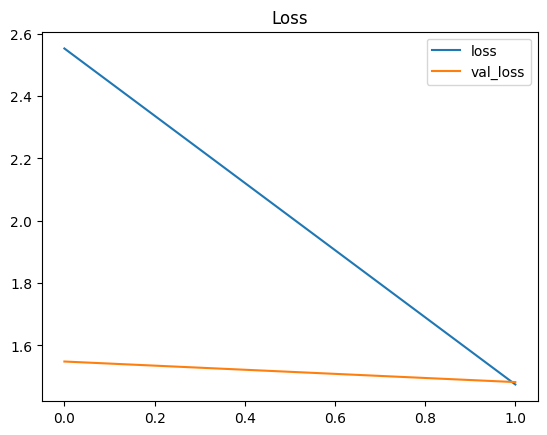

In [11]:
# TRAIN MODEL
translator= Translator(training_size=TRAINING_SIZE)
translator.train()


In [12]:
print(translator.model)

<Sequential name=sequential_1, built=True>


In [13]:
actual, predicted =translator.genereate_test_results()


HINDI (SOURCE)                 ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

##############################################################################
 1. अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें || give your application an accessibility workout || the the the of
##############################################################################
 2. एक्सेर्साइसर पहुंचनीयता अन्वेषक || accerciser accessibility explorer || the the
##############################################################################
 3. निचले पटल के लिए डिफोल्ट प्लगइन खाका || the default plugin layout for the bottom panel || the the the the of
##############################################################################
 4. ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका || the default plugin layout for the top panel || the the the the of of
##############################################################################
 5. उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है || a list of plu

In [ ]:
# # LOAD MODEL AND PARAMETERS FROM DISK
# translator= Translator(training_size=TRAINING_SIZE)
# model_name='15000'
# model_path='../temp_model/'+model_name+"/"
# translator.load_model(model_path=model_path)
# print(translator.target_str,translator.tar_vocab_size)
# actual, predicted =translator.genereate_test_results()
# print(actual, predicted)

In [ ]:
# " ".join(actual[0])

In [14]:
from nltk.translate.bleu_score import corpus_bleu
from sklearn.metrics.pairwise import cosine_similarity
import re
from collections import Counter
import math
from statistics import mean


WORD = re.compile(r"\w+")


def get_cosine_val(word_list_1:[],word_list_2:[]):
    def get_cosine(vec1, vec2):
    
        # get intersecting keys
        intersection = set(vec1.keys()) & set(vec2.keys())
        # multiply and sum weights
        numerator = sum([vec1[x] * vec2[x] for x in intersection])
        # compute denominator
        sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
        sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)
        # return cosine score
        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator
    def text_to_vector(text):
        words = WORD.findall(text)
        return Counter(words)
    
    text1= " ".join(word_list_1)
    text1= text1.lower()
    text2= " ".join(word_list_2)
    text2=text2.lower()
    # turn text into vector counts
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    # compute similarity
    cosine = get_cosine(vector1, vector2)
    return cosine

class PerformanceAnalyser():
    def __init__(self,actual=[], predicted=[]) -> None:
        self.actual=actual
        self.predicted=predicted
        pass

    def bleu_score(self):
        # Get the bleu score of a model
        bleu_dic = {}
        format_actual= [ [sent] for sent in self.actual ]
        bleu_dic['bleu-1-grams'] = corpus_bleu(format_actual, self.predicted, weights=(1.0, 0, 0, 0))
        bleu_dic['bleu-1-2-grams'] = corpus_bleu(format_actual, self.predicted, weights=(0.5, 0.5, 0, 0))
        bleu_dic['bleu-1-3-grams'] = corpus_bleu(format_actual, self.predicted, weights=(0.3, 0.3, 0.3, 0))
        bleu_dic['bleu-1-4-grams'] = corpus_bleu(format_actual, self.predicted, weights=(0.25, 0.25, 0.25, 0.25))
        return bleu_dic
    
    def cosine_score(self):
        cosine_value_list=[]
        actual= self.actual
        predicted=self.predicted
        for a, p in zip(actual, predicted):
            score= get_cosine_val(a,p)
            cosine_value_list.append(score)
            
        average_cosine= mean(cosine_value_list)
        return average_cosine

In [15]:
perf= PerformanceAnalyser(actual, predicted)

In [16]:
perf.bleu_score()

/root/.local/share/virtualenvs/machine-translation-4y6BsU6y/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/root/.local/share/virtualenvs/machine-translation-4y6BsU6y/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/root/.local/share/virtualenvs/machine-translation-4y6BsU6y/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, inde

{'bleu-1-grams': 0.14062715105336177,
 'bleu-1-2-grams': 4.1644181911091095e-155,
 'bleu-1-3-grams': 9.406194489727369e-186,
 'bleu-1-4-grams': 7.166331816971377e-232}

In [17]:
perf.cosine_score()

0.19129177613979742